In [1]:
# helper code, not interesting

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os
import re
import json

# function that gets all notebooks with a given config

def get_df(bitlen, seclvl, mtalg, client_ip, server_ip, min_bandwidth, max_bandwidth, ignore_bandwidth = False):
    names = []
    dicts = process_files_in_directory('../log/', 0, 26, 50)
    for k in dicts:
        # print(f"DEBUG: extracting config from {k}")
        s = ''.join(dicts[k])[50:]
        d = json.loads(s)
        # skip logs before different bit lengths were introduced
        if 'bit_length' not in d['misc']:
            continue
        if d['client']['ip_address'] == client_ip and d['server']['ip_address'] == server_ip:
            if d['misc']['security_level'] == seclvl and d['misc']['mt_algorithm'] == mtalg and d['misc']['bit_length'] == bitlen:
                # print(f"Found file that has appropriate config: {k}")
                bandwidth = extract_bandwidth_from_log_file(f'../log/{k}')
                # print(f'{bandwidth=}')
                if bandwidth:
                    if float(bandwidth) > min_bandwidth and float(bandwidth) < max_bandwidth:
                        names.append(k[6:-4])
                elif ignore_bandwidth:
                    # no bandwidth info
                    names.append(k[6:-4])
    files_to_remove = []
    for file_name in names:
        if not os.path.exists(f'../dfs/{file_name}.csv'):
            # File doesn't exist, add it to the list for removal
            # print(f"df for {file_name} does not exist!")
            files_to_remove.append(file_name)
    
    # Remove the files that don't exist from the original list
    for file_name in files_to_remove:
        names.remove(file_name)
    return pd.concat((pd.read_csv(f"../dfs/{df_name}.csv") for df_name in names), ignore_index=True).reset_index(drop=True)

def read_lines(file_path, start_line, end_line):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        lines = lines[start_line:end_line]
    return lines
def read_until_info(file_path):
    out = []
    with open(file_path, 'r') as file:
        x = file.readline()
        while not 'INFO'in x:
            out.append(x)
            x = file.readline()
    return out
def process_files_in_directory(directory_path, n, m, k):
    result_dict = {}

    # Iterate over files in the directory
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)

        # Check if it's a file (not a directory)
        if os.path.isfile(file_path):
            # Check if the file has more than N rows
            with open(file_path, 'r') as file:
                line_count = sum(1 for _ in file)

            if line_count > k:
                # Read lines n to m from the file
                lines = read_until_info(file_path)

                # Store the lines in a JSON dictionary
                result_dict[filename] = lines

    return result_dict
def remove_chars_after_last_bracket(input_string):
    last_bracket_index = input_string.rfind('}')
    
    if last_bracket_index != -1:
        return input_string[:last_bracket_index + 1]
    else:
        # If there are no closing curly brackets, return the original string
        return input_string
    
def extract_bandwidth_from_log_file(log_file_path):

    # Open the log file and iterate through its lines
    with open(log_file_path, 'r') as log_file:
        for line in log_file:
            # Use a regular expression to match the "Bandwidth:" string and the float value
            match = re.search(r"andwidth: (\d+\.\d+) Mbits/sec", line)
            if match:
                bandwidth_str = match.group(1)
                return(float(bandwidth_str))

    return None

def remove_results_between(df, column, a, b):
    return df[(df[column] > a) & (df[column] < b)] 

# Unstable bandwidth exploration

So far the tests do not produce the expected results. This is due to the fact that the bandwidth available *changes* over time. The results are inconsistent and cannot be compared with each other. Essentially, I was not in control of one of the variables (bandwidth), which has a massive influence on the results.

Here is an example using one of the configurations. The bandwidth is all over the place, which affects the time.

Text(0.5, 1.0, 'Laptop seclvl 80 bit wireless')

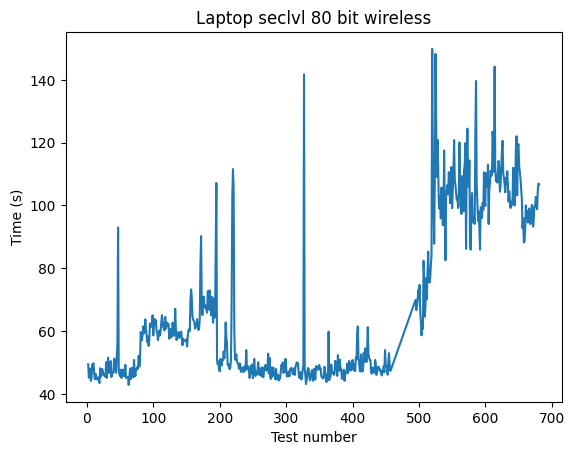

In [2]:
df_80_lap = get_df('32', '80', '0', '192.168.5.111', '192.168.5.112', 1, 30, True)
df_80_lap = remove_results_between(df_80_lap, 'server.timings.total', 0, 160_000)
(df_80_lap['server.timings.total'] / 1000).plot()
plt.xlabel('Test number')
plt.ylabel('Time (s)')
plt.title('Laptop seclvl 80 bit wireless')

Text(0.5, 1.0, 'Laptop seclvl 80 bit wireless')

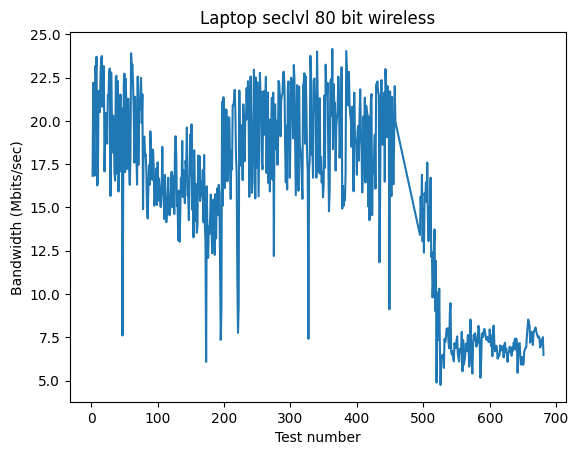

In [3]:
(df_80_lap['server.hardware.throughput'] * 8).plot()
plt.xlabel('Test number')
plt.ylabel('Bandwidth (Mbits/sec)')
plt.title('Laptop seclvl 80 bit wireless')

I thought of a way how to achieve a stable bandwidth and also the same bandwidth on laptops and Raspberry Pis. I connected the devices wirelessly and set a bandwidth limit to 250 Mbits/sec on my managed switch.

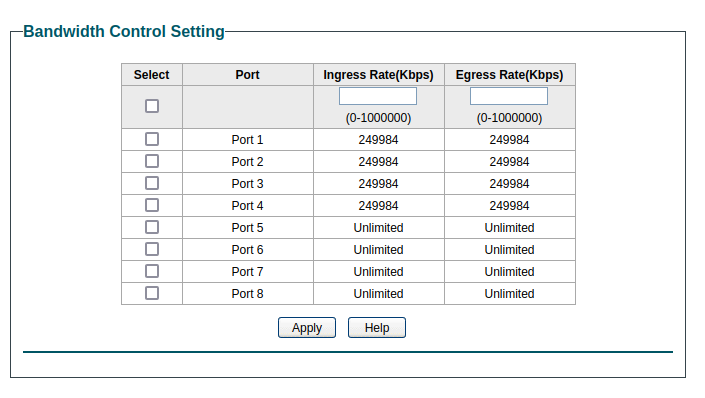

The bandwidth is super stable now. Moreover, I can do more tests since it is 10 times faster than the wireless setting.

Text(0.5, 1.0, 'Laptop seclvl 80 bit (managed switch)')

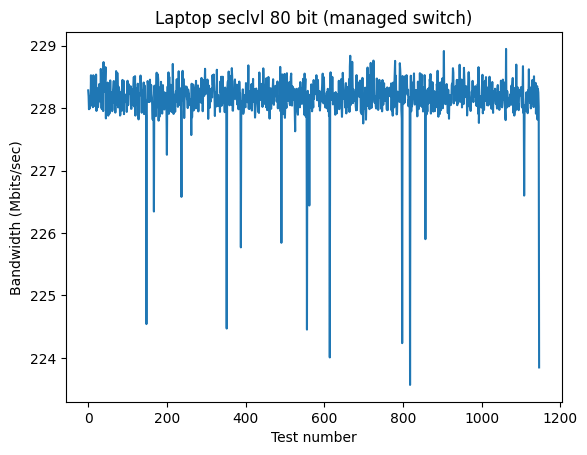

In [4]:
df_80_lap_stable = pd.read_csv('../dfs/2023-09-30_19-06-02.csv')
(df_80_lap_stable['server.hardware.throughput'] * 8).plot()
plt.xlabel('Test number')
plt.ylabel('Bandwidth (Mbits/sec)')
plt.title('Laptop seclvl 80 bit (managed switch)')

Text(0.5, 1.0, 'Laptop seclvl 80 bit (managed switch)')

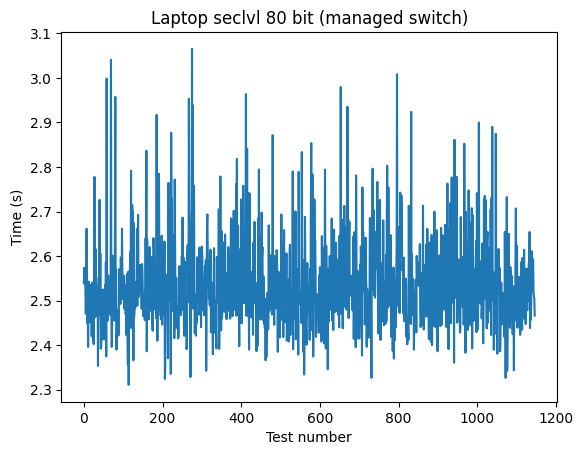

In [5]:
(df_80_lap_stable['server.timings.total'] / 1000).plot()
plt.xlabel('Test number')
plt.ylabel('Time (s)')
plt.title('Laptop seclvl 80 bit (managed switch)')